In [1]:
%cd ..

/Users/arian/Desktop/OptiServe


In [2]:
import numpy as np
import pandas as pd
import boto3
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe


from src.analytics.aws_function_logs import AWSFunctionLogs
from src.profiler.cost_calculator import CostCalculator
from src.modeling.function_performance_modeling import FunctionPerformanceModeling
from src.profiler.explorer import Explorer
from src.optimizer.parametric_function import ParamFunction

In [3]:
memory_bound = (128, 3008)
functions = [
    'f1',
    'f2',
    'f3',
    'f4',
    'f5',
    'f6',
]
memory_space_step = 64

resnet_variant = 'resnet-18'
yolo_variant = 'yolov10n'
bert_variant = 'distilbert-base-uncased'

region_name = 'us-east-1'

In [4]:
# Loading the performance models

p_models_dir = "modeled_functions"

p_models = [ParamFunction.load(f"{p_models_dir}/{function_name}.mdl") for function_name in functions]

In [5]:
logs_dir = "logs"
os.makedirs(logs_dir, exist_ok=True)

In [ ]:
# Extracting the logs

for function_name in functions:
    df = AWSFunctionLogs(
        boto_session=boto3.Session(region_name=region_name),
        function_name=function_name,
    ).get_logs_df(start_time=int((datetime.datetime.utcnow() - datetime.timedelta(days=30)).timestamp()),
        end_time=int(datetime.datetime.utcnow().timestamp()))

    df.to_csv(f'{logs_dir}/{function_name}_logs.csv')

In [6]:
cost_calculator = CostCalculator()

In [7]:
dfs = [pd.read_csv(f'{logs_dir}/{function_name}_logs.csv') for function_name in functions]

In [8]:
logs_list = []

for df in dfs:
    logs = df[df['Init Duration'].isna()]

    logs = logs.groupby('Memory Size').agg({
        'Duration': 'mean',
    }).reset_index()

    if 'Duration' in logs.columns and 'Memory Size' in logs.columns:
        logs.loc[:, 'Cost'] = logs.apply(
            lambda row: cost_calculator.calculate_cost(
                memory_mb=row['Memory Size'],
                duration_ms=row['Duration']
            ),
            axis=1
        )
    logs_list.append(logs)

In [9]:
memory_space = np.arange(memory_bound[0], memory_bound[1] + 1, step=memory_space_step)

for i, logs in enumerate(logs_list):
    logs_list[i] = logs[logs['Memory Size'].isin(memory_space)]

In [10]:
def compute_cdf(values):
    values = np.sort(values)
    cdf = np.arange(1, len(values) + 1) / len(values)
    return values, cdf

In [11]:
duration_cdf_data = {}
cost_cdf_data = {}

for i, function_name in enumerate(functions):

    df = logs_list[i]  # pandas dataframe for this function

    # --- 1. Group by memory size and compute medians ---
    grouped = df.groupby("Memory Size").agg({
        "Duration": "median",
        "Cost": "median"
    }).reset_index()

    true_durations = grouped["Duration"].values
    true_costs = grouped["Cost"].values
    memory_sizes = grouped["Memory Size"].values

    # --- 2. Compute predictions for each memory tier ---
    pred_durations = np.array([p_models[i](mem) for mem in memory_sizes])
    pred_costs = np.array([
        cost_calculator.calculate_cost(memory_mb=mem, duration_ms=p_models[i](mem))
        for mem in memory_sizes
    ])

    # --- 3. Compute MAPE per memory tier ---
    duration_mape_values = np.abs(true_durations - pred_durations) / true_durations * 100
    cost_mape_values = np.abs(true_costs - pred_costs) / true_costs * 100

    duration_cdf_data[function_name] = duration_mape_values
    cost_cdf_data[function_name] = cost_mape_values

    print(f"\n🔹 {function_name}:")
    print(f"   Median Duration MAPE values per tier: {duration_mape_values}")
    print(f"   Median Cost MAPE values per tier:     {cost_mape_values}")


🔹 f1:
   Median Duration MAPE values per tier: [ 4.72996743 22.21438585 33.85261622 27.21841378 23.99428105 21.65111368
 14.19350502  8.07309796  2.01505074  0.69713301  4.98362416  6.0816333
  6.82434725  8.80717542  9.58354795  6.29912081  6.0765753   5.45327199
  0.21844784  1.79872371  1.1612494   6.3900943   8.09642957 12.05882316
  6.65260167  5.88127714  7.32844755  4.9572091   3.94046792  6.7735937
  3.9076496   4.12097403  6.70088608  7.33621522 14.02829716  6.06771381
  7.29603615  6.7954765   9.31897954  2.86811485  0.52036848  9.09972465
  8.43662222  7.58100465  4.37848159  5.84182091]
   Median Cost MAPE values per tier:     [ 4.59016422 21.50485571 32.7309258  26.38711896 23.291628   20.91449456
 13.64829482  7.85961493  1.97303531  0.55406317  4.80961955  5.96330314
  6.73539563  8.42266518  9.43396287  6.1893208   5.85215644  5.14295415
  0.34770517  1.81723792  1.10000007  6.26596329  7.63052258 11.31221792
  6.44162318  6.04567881  7.38137124  4.82662994  3.59424939

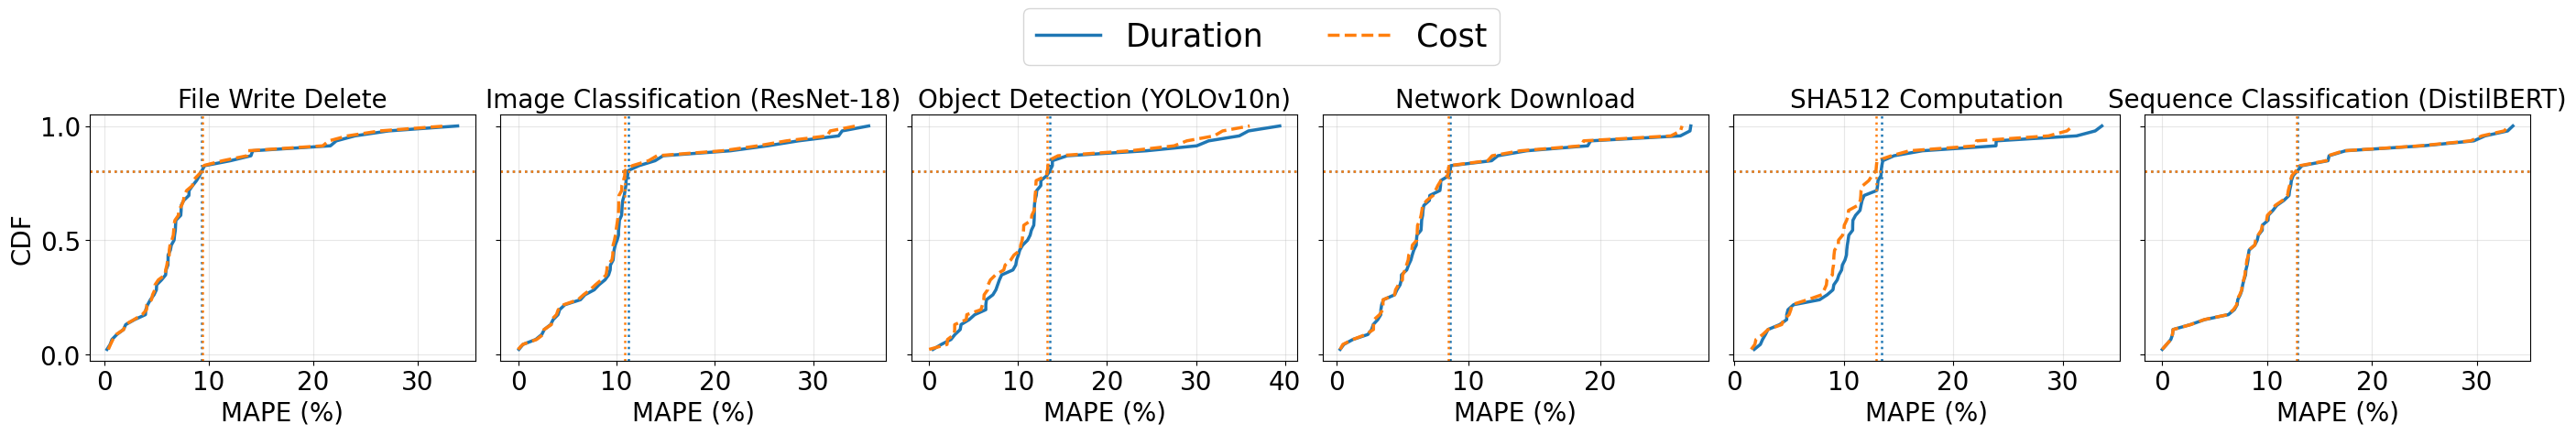

In [24]:
function_labels = [
    'File Write Delete',
    'Image Classification (ResNet-18)',
    'Object Detection (YOLOv10n)',
    'Network Download',
    'SHA512 Computation',
    'Sequence Classification (DistilBERT)',
]

plt.rcParams.update({
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.titlesize": 20
})

fig, axes = plt.subplots(1, 6, figsize=(28, 4), sharey=True)

legend_handles = None
percentile_level = 0.80  # 80th percentile

for idx, (func_key, ax) in enumerate(zip(duration_cdf_data.keys(), axes)):

    func_label = function_labels[idx]
    duration_vals = duration_cdf_data[func_key]
    cost_vals = cost_cdf_data[func_key]

    dur_x, dur_y = compute_cdf(duration_vals)
    cost_x, cost_y = compute_cdf(cost_vals)

    # Lines
    h1 = ax.plot(dur_x, dur_y, label="Duration", linewidth=2.5)
    h2 = ax.plot(cost_x, cost_y, label="Cost", linewidth=2.5, linestyle='--')

    # Capture legend handles once
    if legend_handles is None:
        legend_handles = (h1[0], h2[0])

    # Compute 80th percentiles
    dur_p80 = np.percentile(duration_vals, 80)
    cost_p80 = np.percentile(cost_vals, 80)

    # Plot vertical and horizontal lines for Duration
    ax.axvline(dur_p80, color=h1[0].get_color(), linestyle=':', linewidth=1.8)
    ax.axhline(0.80, color=h1[0].get_color(), linestyle=':', linewidth=1.8)

    # Plot vertical and horizontal lines for Cost
    ax.axvline(cost_p80, color=h2[0].get_color(), linestyle=':', linewidth=1.8)
    ax.axhline(0.80, color=h2[0].get_color(), linestyle=':', linewidth=1.8)

    ax.set_title(func_label)
    ax.set_xlabel("MAPE (%)")
    ax.grid(alpha=0.3)

# Shared Y label
axes[0].set_ylabel("CDF")

# One shared legend
fig.legend(
    legend_handles,
    ["Duration", "Cost"],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.22),
    ncol=2,
    fontsize=25
)

plt.tight_layout()
plt.savefig("mape_cdf_functions.pdf", bbox_inches="tight")
plt.show()
